<h2>Step 1: Import Required Libraries</h2>
<p>We begin by importing necessary libraries such as NumPy, Matplotlib, and scikit-learn modules.</p>


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

<h2>Step 2: Load the Digits Dataset</h2>
<p>We load the built-in digits dataset from scikit-learn, which contains handwritten digit samples.</p>


In [14]:
digits = load_digits()
X = digits.data
y = digits.target
print("Dataset shape:", X.shape)


Dataset shape: (1797, 64)


<h2>Step 3: Filter to Only Three Digit Classes</h2>
<p>We select samples corresponding to only the digits 2, 5, and 8.</p>


In [15]:
selected_classes = [2, 5, 8]
mask = np.isin(y, selected_classes)
X_selected = X[mask]
y_selected = y[mask]
print("Selected data shape:", X_selected.shape)


Selected data shape: (533, 64)


<h2>Step 4: Dimensionality Reduction using PCA</h2>
<p>We reduce the dimensionality of the data to 2D for visualization and clustering using PCA.</p>


In [16]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_selected)
print("PCA reduced shape:", X_pca.shape)


PCA reduced shape: (533, 2)


<h2>Step 5: Apply KMeans Clustering</h2>
<p>We apply KMeans clustering to the PCA-transformed 2D data and extract the predicted cluster labels.</p>


In [17]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)
print("Cluster labels:", np.unique(clusters))


Cluster labels: [0 1 2]


<h2>Step 6: Visualize Clusters vs. Actual Labels</h2>
<p>We plot the results of KMeans clustering side-by-side with the true labels of the digits.</p>


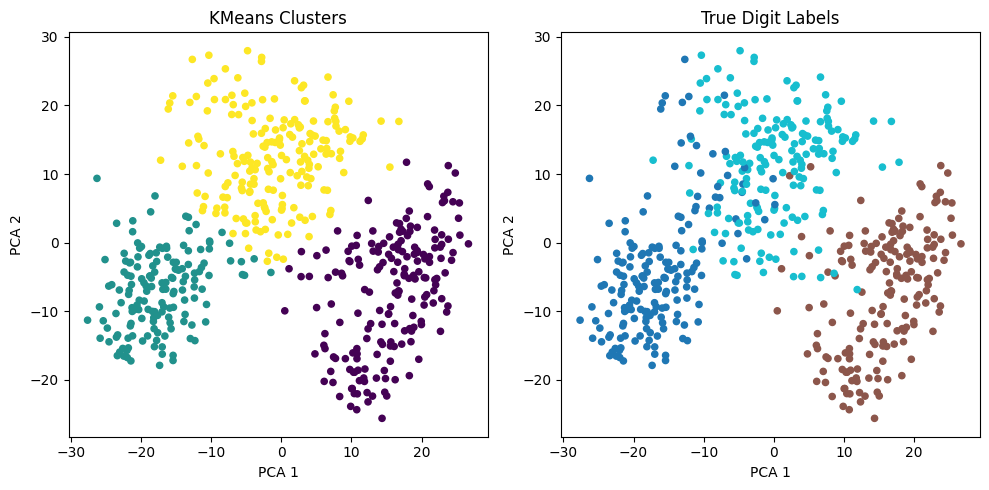

In [18]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=20)
plt.title('KMeans Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_selected, cmap='tab10', s=20)
plt.title('True Digit Labels')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()


<h2>Step 7: Use the Elbow Method to Determine Optimal k</h2>
<p>We use the Elbow Method by plotting inertia vs. the number of clusters (k) to find the best value of k.</p>


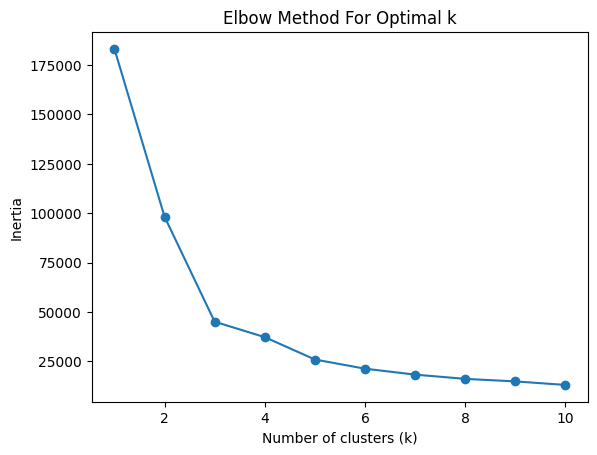

In [ ]:
inertias = [] # cost functions
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca)
    inertias.append(km.inertia_)

plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


<h2>Step 8: Implement Gaussian Mixture Model (GMM) from Scratch</h2>
<p>We implement the GMM algorithm using the Expectation-Maximization (EM) procedure with support for 'full' and 'diag' covariance types.</p>

<p>full = GMM assumes features are correlated.</p>
<p>diag = GMM assumes features are uncorrelated.</p>


In [ ]:
class MyGMM:
    def __init__(self, n_components=3, covariance_type='full', max_iter=100, tol=1e-4, random_state=42):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        np.random.seed(random_state)
    
    def _init_params(self, X):
        n_samples, n_features = X.shape
        rng = np.random.default_rng(self.random_state)
        indices = rng.choice(n_samples, self.n_components, replace=False)
        self.means_ = X[indices] # Randomly select initial means (centroids)
        self.weights_ = np.ones(self.n_components) / self.n_components
        
        if self.covariance_type == 'full':
            self.covariances_ = np.array([np.cov(X, rowvar=False)] * self.n_components)
        elif self.covariance_type == 'diag':
            self.covariances_ = np.array([np.diag(np.var(X, axis=0))] * self.n_components)
        else:
            raise ValueError("Unsupported covariance_type")
    
    def _gaussian(self, X, mean, cov):
        n = X.shape[1]
        cov = np.atleast_2d(cov)
        diff = X - mean
        try:
            inv_cov = np.linalg.inv(cov)
            det_cov = np.linalg.det(cov)
        except np.linalg.LinAlgError:
            cov += 1e-6 * np.eye(n) # Add small value to diagonal if singular
            inv_cov = np.linalg.inv(cov)
            det_cov = np.linalg.det(cov)
        norm_const = 1. / np.sqrt((2 * np.pi) ** n * det_cov) # normalization constant
        return norm_const * np.exp(-0.5 * np.sum(diff @ inv_cov * diff, axis=1)) # final probability
    
    def fit(self, X):
        n_samples, n_features = X.shape
        self._init_params(X)
        log_likelihoods = []
        for iteration in range(self.max_iter):
            # E-step
            resp = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                resp[:, k] = self.weights_[k] * self._gaussian(X, self.means_[k], self.covariances_[k])
            resp_sum = resp.sum(axis=1, keepdims=True)
            resp = resp / resp_sum
            # M-step
            N_k = resp.sum(axis=0) # Effective number of samples for each cluster
            self.weights_ = N_k / n_samples
            self.means_ = (resp.T @ X) / N_k[:, np.newaxis]
            for k in range(self.n_components):
                diff = X - self.means_[k]
                if self.covariance_type == 'full':
                    self.covariances_[k] = (resp[:, k][:, np.newaxis] * diff).T @ diff / N_k[k]
                elif self.covariance_type == 'diag':
                    var = np.sum(resp[:, k][:, np.newaxis] * diff ** 2, axis=0) / N_k[k]
                    self.covariances_[k] = np.diag(var)
            # Log-likelihood
            log_likelihood = np.sum(np.log(resp_sum))
            log_likelihoods.append(log_likelihood)
            # Check for convergence
            if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < self.tol:
                break
        self.resp_ = resp
        self.log_likelihoods_ = log_likelihoods
        return self

    def predict(self, X):
        probs = np.array([self.weights_[k] * self._gaussian(X, self.means_[k], self.covariances_[k])
                          for k in range(self.n_components)]).T
        return np.argmax(probs, axis=1)


<h2>Step 9: Run the Custom GMM with Full and Diagonal Covariance</h2>
<p>We fit two versions of the GMM model to the PCA-reduced data using both 'full' and 'diag' covariance types.</p>


In [21]:
gmm_full = MyGMM(n_components=3, covariance_type='full', max_iter=50, random_state=42)
gmm_diag = MyGMM(n_components=3, covariance_type='diag', max_iter=50, random_state=42)

gmm_full.fit(X_pca)
gmm_diag.fit(X_pca)

labels_full = gmm_full.predict(X_pca)
labels_diag = gmm_diag.predict(X_pca)


<h2>Step 10: Plot Log-Likelihoods</h2>
<p>We verify that the log-likelihood increases during each EM iteration for both covariance types.</p>


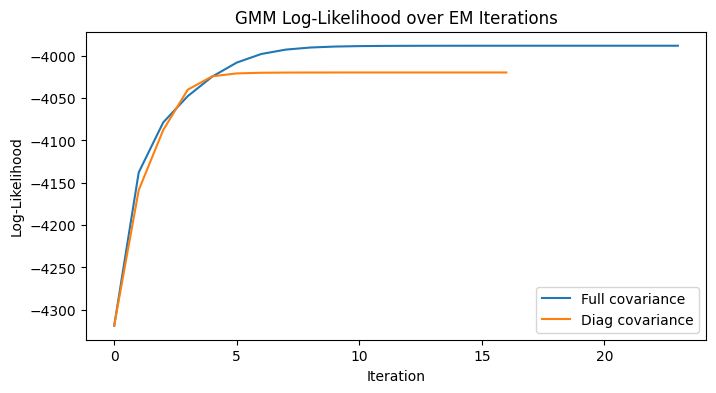

In [22]:
plt.figure(figsize=(8, 4))
plt.plot(gmm_full.log_likelihoods_, label="Full covariance")
plt.plot(gmm_diag.log_likelihoods_, label="Diag covariance")
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('GMM Log-Likelihood over EM Iterations')
plt.legend()
plt.show()


<h2>Step 11: Visualize GMM Cluster Assignments</h2>
<p>We display the clusters predicted by the GMM algorithm for both covariance configurations.</p>


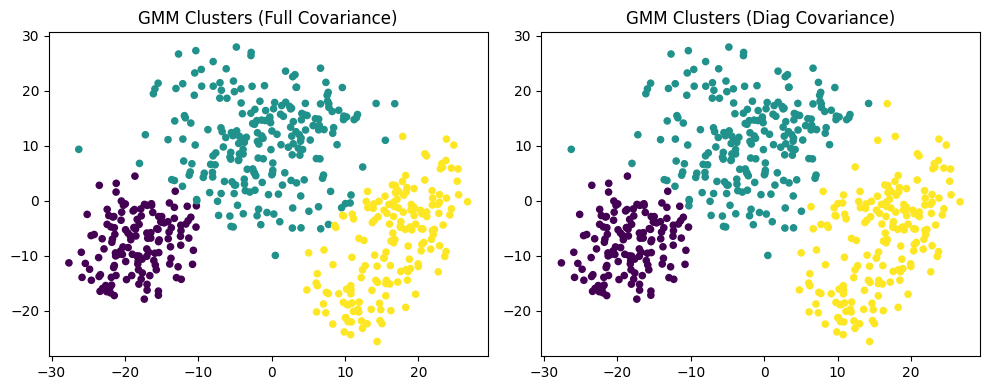

In [23]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_full, cmap='viridis', s=20)
plt.title('GMM Clusters (Full Covariance)')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_diag, cmap='viridis', s=20)
plt.title('GMM Clusters (Diag Covariance)')

plt.tight_layout()
plt.show()
